In [1]:

import reverse_geocoder as rg

In [3]:
import pandas as pd


# 1. data
df = pd.read_excel('raw_data_9.xlsx')  # file path

# 2. extract altitude and longitude with countries' information extraction
coordinates = list(zip(df['latitude_deg'], df['longitude_deg']))
results = rg.search(coordinates)  # back to dict

# 3. needed data(code , name, region/admin
country_data = {
    'country_code': [result['cc'] for result in results],      # code(US
    'country_name': [result['name'] for result in results],    # full name
    'admin1': [result['admin1'] for result in results]         # admin
}

# 4. attach to  DataFrame
df = pd.concat([df, pd.DataFrame(country_data)], axis=1)  

# 5. show
print(df.head())

# 6. save
df.to_excel('raw_data_9_with_countries.xlsx', index=False)

Loading formatted geocoded file...
   latitude_deg  longitude_deg  depth_m  elevation_m           env_feature  \
0         43.63         -80.39     0.05        370.0  agricultural feature   
1         43.64         -80.41     0.05        374.0  agricultural feature   
2         64.87        -111.58     0.05        416.0                tundra   
3         69.33        -138.74     0.05         16.0             clay soil   
4         57.29        -111.27     0.05        333.0           forest soil   

   adiv_shannon   ph country_code    country_name                 admin1  
0      8.249587  7.6           CA          Guelph                Ontario  
1      8.688437  7.4           CA          Guelph                Ontario  
2      7.363660  3.9           CA     Yellowknife  Northwest Territories  
3      7.728992  6.7           CA  Fort McPherson  Northwest Territories  
4      7.133368  4.6           CA   Fort McMurray                Alberta  


In [3]:
# shanon by country
import pandas as pd

#load
df = pd.read_excel('raw_data_9_with_countries.xlsx')

# code->full name
country_code_to_name = {
    'CA': 'Canada',
    'US': 'United States',
    'MX': 'Mexico',
    'PA': 'Panama',
    'PE': 'Peru',
    'AR': 'Argentina',
    'CN': 'China',
    'IN': 'India',
    'NZ': 'New Zealand',
    'GB': 'United Kingdom',
    'AQ': 'Antarctica',
    'RU': 'Russia',
    'AU': 'Australia',
    'PR': 'Puerto Rico'  # Puerto Rico can be US
}

# std name attach
df['standard_country_name'] = df['country_code'].map(country_code_to_name)

# result
print(df[['country_code', 'country_name', 'standard_country_name']].drop_duplicates())
df.to_excel('raw_data_9_with_countries.xlsx', index=False)




    country_code       country_name standard_country_name
0             CA             Guelph                Canada
2             CA        Yellowknife                Canada
3             CA     Fort McPherson                Canada
4             CA      Fort McMurray                Canada
5             CA        Dawson City                Canada
..           ...                ...                   ...
609           PA           El Giral                Panama
611           PA     Nuevo San Juan                Panama
616           PA  Nueva Providencia                Panama
625           PA           Chilibre                Panama
632           AU        Goonellabah             Australia

[104 rows x 3 columns]


In [12]:
print(df[['country_code', 'country_name']].drop_duplicates())


    country_code       country_name
0             CA             Guelph
2             CA        Yellowknife
3             CA     Fort McPherson
4             CA      Fort McMurray
5             CA        Dawson City
..           ...                ...
609           PA           El Giral
611           PA     Nuevo San Juan
616           PA  Nueva Providencia
625           PA           Chilibre
632           AU        Goonellabah

[104 rows x 2 columns]


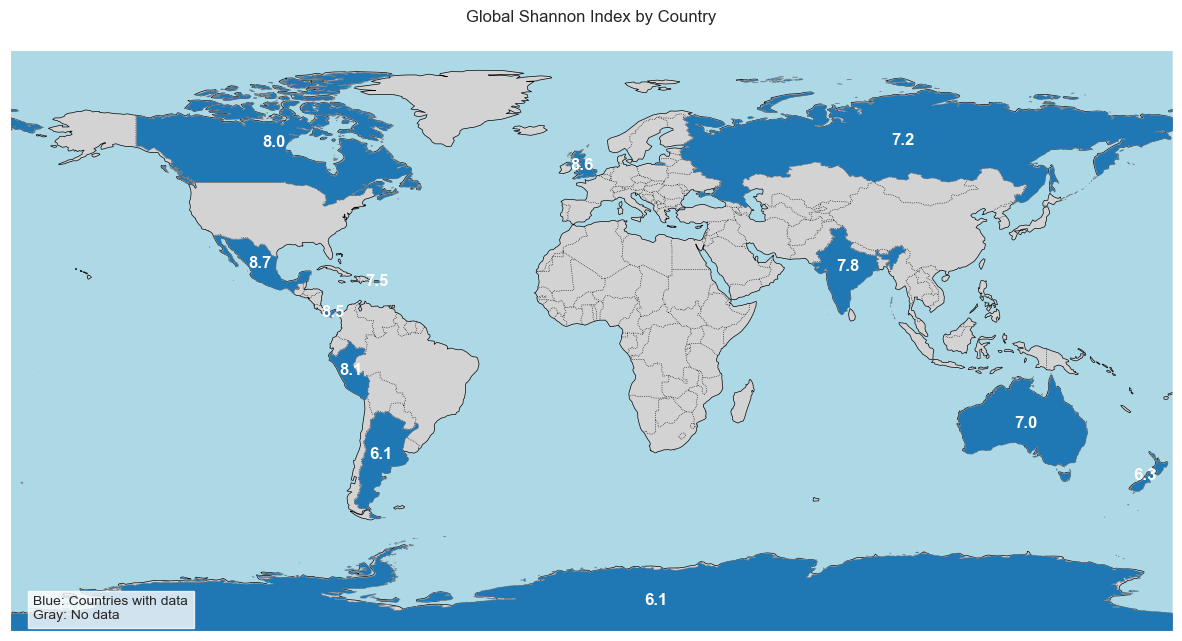

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader

# 1. ave
df = pd.read_excel('raw_data_9_with_countries.xlsx')
country_stats = df.groupby('standard_country_name')['adiv_shannon'].mean().reset_index()

# 2. map
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# setting
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor='lightgray')  #no data region
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# load data from naturalearth
countries_shp = shapereader.natural_earth(
    resolution='50m',
    category='cultural',
    name='admin_0_countries'
)

# special admins
name_mapping = {
    'United Kingdom': 'United Kingdom',  # Scotland → UK
    'Antarctica': 'Antarctica',         # McMurdo Station → Antarctica
    'Russia': 'Russia',                 # Cherskiy → Russia
    'Puerto Rico': 'Puerto Rico'        # take special apart
}

# for results
for idx, row in country_stats.iterrows():
    country_name = row['standard_country_name']
    shannon_val = row['adiv_shannon']


    naturalearth_name = name_mapping.get(country_name, country_name)

    # find boundaries
    for country in shapereader.Reader(countries_shp).records():
        if country.attributes['NAME_EN'] == naturalearth_name:
            # fill country
            ax.add_geometries(
                [country.geometry],
                crs=ccrs.PlateCarree(),
                facecolor='#1f77b4',  # fill data country
                edgecolor='gray',
                linewidth=0.3
            )

            # text
            centroid = country.geometry.centroid
            ax.text(
                centroid.x,
                centroid.y,
                f"{shannon_val:.1f}",
                fontsize=12,
                ha='center',
                va='center',
                color='white',
                weight='bold'
            )
            break

# title
plt.title('Global Shannon Index by Country', pad=20)
ax.text(0.02, 0.02,
        'Blue: Countries with data\nGray: No data',
        transform=ax.transAxes,
        bbox=dict(facecolor='white', alpha=0.8))

plt.savefig('Shannon_Index_Map.png', dpi=300, bbox_inches='tight')
plt.show()


